In [201]:
import pandas as pd

# for feature selection
from sklearn.feature_selection import mutual_info_classif

# for graph plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for adaboost
from sklearn.ensemble import AdaBoostClassifier

# for xgboost
from xgboost import XGBClassifier

# for evaluation metrics
%run -i helper_functions.py

# for multi-label classification
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

import warnings
warnings.filterwarnings("ignore")

## Feature Selection

In [4]:
featured_train = pd.read_csv('Data/featured_train.csv')

In [5]:
embeddings_glove = pd.read_csv('embeddings_glove.csv')

In [22]:
features = featured_train.columns[13:-1]

In [23]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(featured_train[features])

In [24]:
combined_train = embeddings_glove.copy()
combined_train[features] = scaled

In [25]:
combined_train.head()

,0,1,2,3,4,5,6,7,8,9,...,bad_obscene_vs_words,num_bad_threat,bad_threat_vs_length,bad_threat_vs_words,num_bad_insult,bad_insult_vs_length,bad_insult_vs_words,num_bad_identity_hate,bad_identity_hate_vs_length,bad_identity_hate_vs_words
0,0.020071,0.067968,-0.062794,0.045805,-0.026198,0.020383,0.394938,-0.045788,-0.071278,-0.078638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.085630,0.083147,-0.136207,0.008497,0.001106,0.109956,0.299174,-0.164092,-0.107027,-0.068148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.108352,0.208866,-0.025381,0.109339,-0.099575,0.112354,0.582873,-0.029074,-0.069566,-0.112938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.042564,0.198714,-0.006755,0.121494,-0.086642,0.084517,0.527498,-0.066771,-0.103323,0.015370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.092235,0.236658,-0.054219,0.082956,-0.179523,0.100652,0.663226,0.062394,-0.112727,-0.010951,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [33]:
train_X = combined_train.drop(labels+['none'], axis=1)

In [49]:
# get the feature importance based on information gain
feature_importance = []
for label in labels:
    print(f'getting feature importance for label {label}')
    importance = mutual_info_classif(train_X, combined_train[label])
    importance_df = pd.DataFrame({'Features': train_X.columns, 'Importance': importance})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    feature_importance.append(importance_df)

getting feature importance for label toxic
getting feature importance for label severe_toxic
getting feature importance for label obscene
getting feature importance for label threat
getting feature importance for label insult
getting feature importance for label identity_hate


In [134]:
for i in range(len(feature_importance)):
    feature_importance[0].to_csv(f'{labels[i]}_feature_importance.csv', index=False)

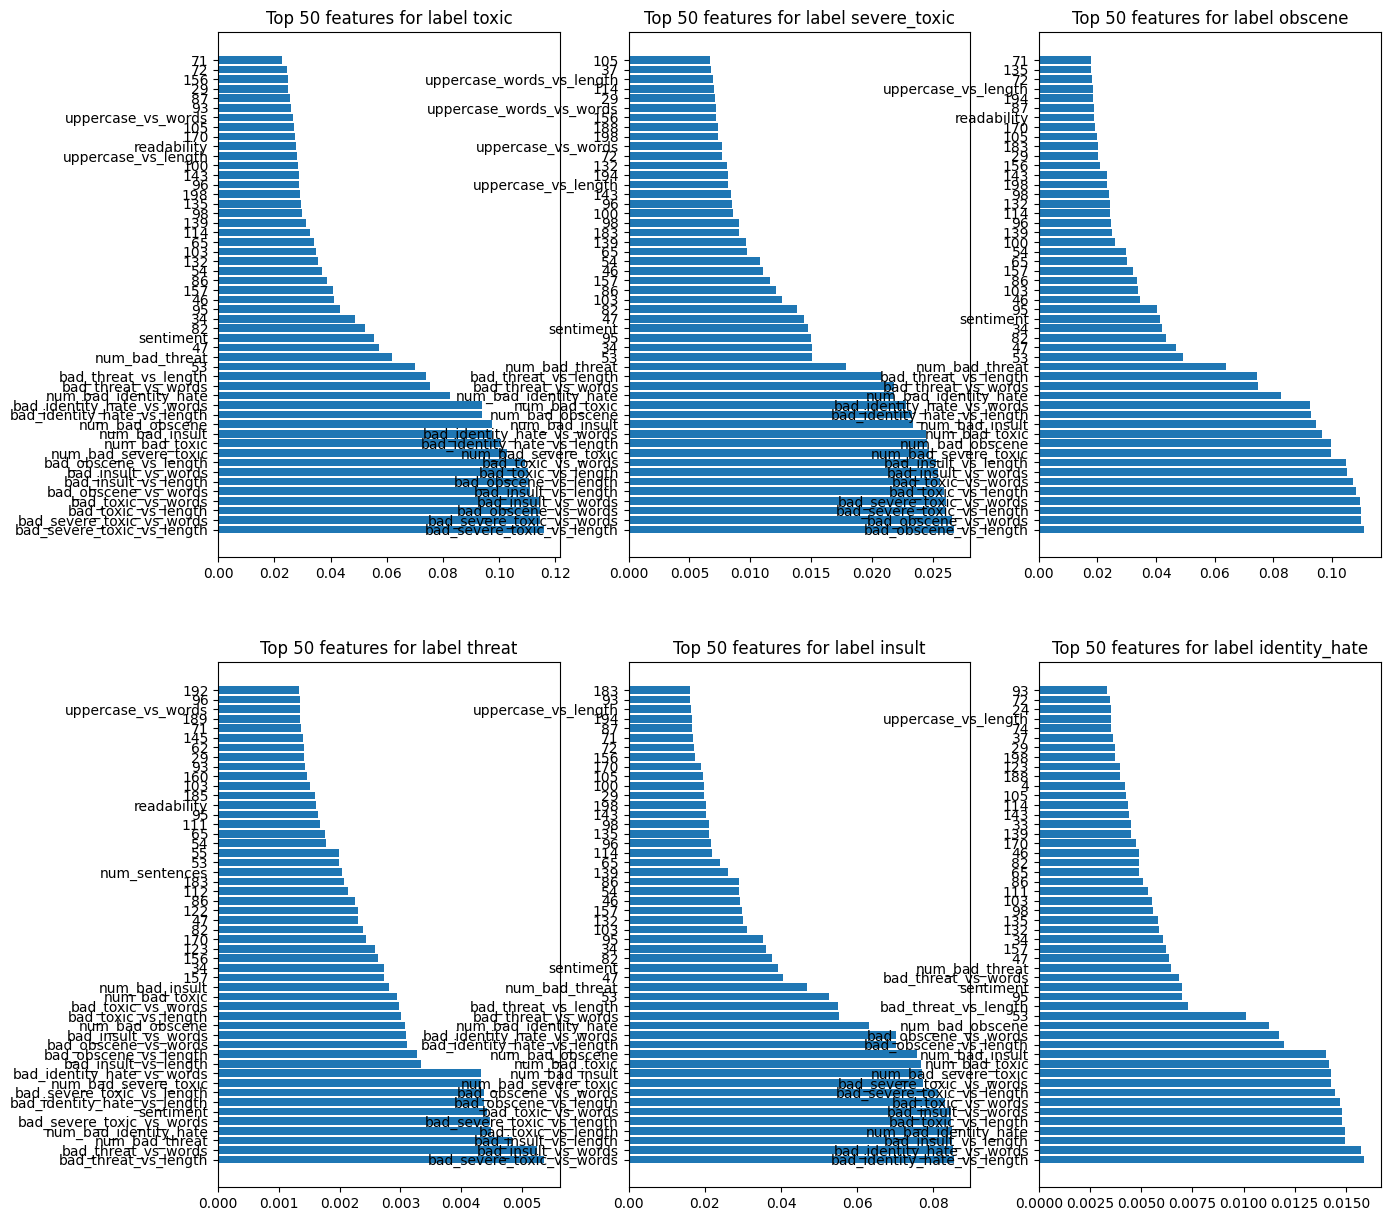

In [75]:
# get the top 50 features for each label based on information gain
feature_importance_top = list(map(lambda x: x[:50], feature_importance))
fig, axes = plt.subplots(2, 3, figsize=(15,15))
for i in range(len(feature_importance_top)):
    axes[i//3, i%3].barh(feature_importance_top[i]['Features'], feature_importance_top[i]['Importance'])
    axes[i//3, i%3].set_title(f'Top 50 features for label {labels[i]}')
plt.show()

In [69]:
selected_train = pd.read_csv('Data\selected_train.csv')

In [79]:
selected_features = list(selected_train.columns[7:])

In [81]:
selected_features[0] = 'min_length'
selected_features[3] = 'num_unique_words'
selected_features[5] = 'num_uppercase'

In [73]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [83]:
# get the intersections of selected features and top features in each category
intersections = []
for i in range(len(feature_importance_top)):
    inter = intersection(feature_importance_top[i].Features, selected_features)
    print(f'{len(inter)} common features for label {labels[i]}')
    intersections.append(inter)

35 common features for label toxic
31 common features for label severe_toxic
34 common features for label obscene
22 common features for label threat
35 common features for label insult
30 common features for label identity_hate


In [91]:
# count the number of occurrences of each top feature
features_count = {}
for i in range(len(feature_importance_top)):
    for feature in feature_importance_top[i].Features:
        if feature not in features_count.keys():
            features_count[feature] = 1
        else:
            features_count[feature] += 1

In [119]:
# identify the top features for minority categories
minority_features = list(feature_importance_top[1].Features)+list(feature_importance_top[3].Features)+list(feature_importance_top[5].Features)

In [131]:
colors = []
for feature in features_count.keys():
    if feature in selected_features:
        colors.append('g')
    elif feature in minority_features:
        colors.append('r')
    else:
        colors.append('y')

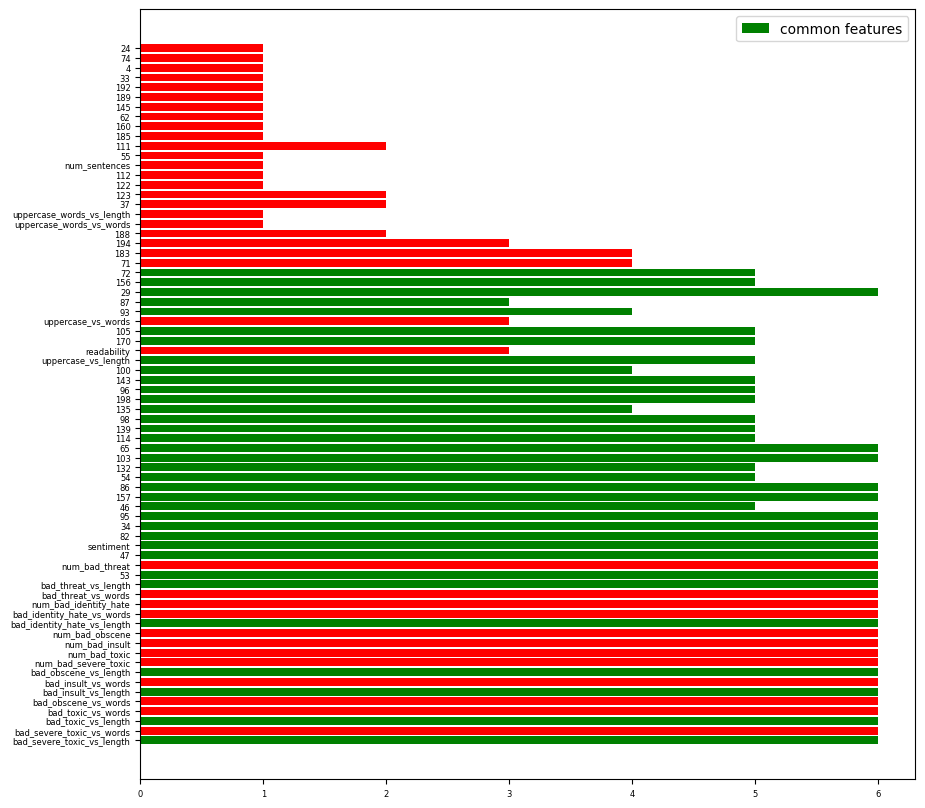

In [132]:
# plot the count plot of top features 
fig, ax = plt.subplots(figsize =(10, 10))
ax.barh(list(features_count.keys()), list(features_count.values()), color=colors)
ax.tick_params(labelsize=6)
plt.legend(['common features'])
plt.show()

## Read Test Data

In [187]:
selected_test = pd.read_csv('Data\selected_test.csv')

In [188]:
selected_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,min_length_scaled,num_words_vs_length,exclamation_marks_vs_length,num_unique_words_scaled,...,114,132,135,139,143,156,157,170,198,none
0,0,0,0,0,0,0,0.002890,0.166667,0.000000,0.032911,...,0.040738,-0.010083,-0.158238,-0.204194,0.116565,0.098296,-0.206160,0.046779,-0.036748,1
1,0,0,0,0,0,0,0.005058,0.187500,0.000000,0.015190,...,-0.013467,0.003550,-0.117174,-0.075475,0.043945,-0.148617,-0.350740,0.113815,-0.070907,1
2,0,0,0,0,0,0,0.000723,0.149554,0.002232,0.118987,...,-0.125080,0.045087,-0.119656,-0.274707,0.102546,0.100782,-0.107205,-0.050780,-0.098343,1
3,0,0,0,0,0,0,0.007225,0.169661,0.000000,0.070886,...,-0.023304,-0.005002,-0.281848,-0.157011,0.184323,0.067625,-0.066242,0.023737,-0.111269,1
4,0,0,0,0,0,0,0.003613,0.167665,0.000000,0.060759,...,0.055657,0.024936,-0.181419,-0.165707,0.194511,0.143557,-0.059017,0.136676,-0.004530,1


For boosting methods, they deal with class imbalance by constructing successive training sets based on incorrectly classified examples. So it seems not to be necessary to introduce a kind of class_weight parameter.

## Adaboost

### Baseline Adaboost using BinaryRelevance

In [193]:
classifier_ab = BinaryRelevance(AdaBoostClassifier(random_state=0))
# train
classifier_ab.fit(selected_train[features], selected_train[labels])
# predict
predictions_ab = classifier_ab.predict(selected_train[features])

In [194]:
# predict probability
predictions_proba_ab = classifier_ab.predict_proba(selected_train[features])

In [184]:
# model evaluation
get_evaluation_score(selected_train[labels], predictions_ab, predictions_proba_ab)

Accuracy score:  0.9125404992135162
Precision score:  0.7770655169870151
Recall score:  0.6020286056185538
F1 score:  0.677373812686023
Confusion matrix for label toxic:
[[142505   1772]
 [  5597   9697]]
Confusion matrix for label severe_toxic:
[[157317    659]
 [   992    603]]
Confusion matrix for label obscene:
[[149889   1233]
 [  2689   5760]]
Confusion matrix for label threat:
[[158920    173]
 [   369    109]]
Confusion matrix for label insult:
[[150138   1556]
 [  3143   4734]]
Confusion matrix for label identity_hate:
[[157765    401]
 [  1178    227]]
Logarithmic Loss:  0.3880227138605389
ROC AUC score:  0.9677564790633872


In [195]:
# evaluation on test data
predictions_ab_test = classifier_ab.predict(selected_test[features])
predictions_proba_ab_test = classifier_ab.predict_proba(selected_test[features])
get_evaluation_score(selected_test[labels], predictions_ab_test, predictions_proba_ab_test)

Accuracy score:  0.8834130482353308
Precision score:  0.5983698968268324
Recall score:  0.6262243068009381
F1 score:  0.6075640597512085
Confusion matrix for label toxic:
[[55070  2818]
 [ 1740  4350]]
Confusion matrix for label severe_toxic:
[[63216   395]
 [  199   168]]
Confusion matrix for label obscene:
[[58814  1473]
 [ 1260  2431]]
Confusion matrix for label threat:
[[63683    84]
 [  142    69]]
Confusion matrix for label insult:
[[59461  1090]
 [ 1518  1909]]
Confusion matrix for label identity_hate:
[[63051   215]
 [  560   152]]
Logarithmic Loss:  0.3994778359106472
ROC AUC score:  0.953405666218833


### Baseline Adaboost using ClassifierChain

In [197]:
classifier_chain_ab = ClassifierChain(AdaBoostClassifier(random_state=0))
# train
classifier_chain_ab.fit(selected_train[features], selected_train[labels])
# predict
predictions_chain_ab = classifier_chain_ab.predict(selected_train[features])

In [198]:
# predict probability
predictions_proba_chain_ab = classifier_chain_ab.predict_proba(selected_train[features])

In [199]:
# model evaluation
get_evaluation_score(selected_train[labels], predictions_chain_ab, predictions_proba_chain_ab)

Accuracy score:  0.9135745216862713
Precision score:  0.7460722264367039
Recall score:  0.631431990426805
F1 score:  0.6779039904300239
Confusion matrix for label toxic:
[[142505   1772]
 [  5597   9697]]
Confusion matrix for label severe_toxic:
[[157653    323]
 [  1181    414]]
Confusion matrix for label obscene:
[[149151   1971]
 [  2112   6337]]
Confusion matrix for label threat:
[[158962    131]
 [   391     87]]
Confusion matrix for label insult:
[[149050   2644]
 [  2452   5425]]
Confusion matrix for label identity_hate:
[[157704    462]
 [  1203    202]]
Logarithmic Loss:  0.38481131371737654
ROC AUC score:  0.965623896018629


In [200]:
# evaluation on test data
predictions_chain_ab_test = classifier_chain_ab.predict(selected_test[features])
predictions_proba_chain_ab_test = classifier_chain_ab.predict_proba(selected_test[features])
get_evaluation_score(selected_test[labels], predictions_chain_ab_test, predictions_proba_chain_ab_test)

Accuracy score:  0.8864453405858264
Precision score:  0.5464551013009245
Recall score:  0.6650572492757622
F1 score:  0.5970707628466516
Confusion matrix for label toxic:
[[55070  2818]
 [ 1740  4350]]
Confusion matrix for label severe_toxic:
[[63392   219]
 [  241   126]]
Confusion matrix for label obscene:
[[58038  2249]
 [ 1012  2679]]
Confusion matrix for label threat:
[[63692    75]
 [  140    71]]
Confusion matrix for label insult:
[[58352  2199]
 [ 1153  2274]]
Confusion matrix for label identity_hate:
[[62989   277]
 [  570   142]]
Logarithmic Loss:  0.39687511432535383
ROC AUC score:  0.9507304676178021


### Baseline Adaboost using LabelPowerset

Model with the worst performance.

In [203]:
classifier_powerset_ab = LabelPowerset(AdaBoostClassifier(random_state=0))
# train
classifier_powerset_ab.fit(selected_train[features], selected_train[labels])
# predict
predictions_powerset_ab = classifier_powerset_ab.predict(selected_train[features])

In [207]:
# predict probability
predictions_proba_powerset_ab = classifier_powerset_ab.predict_proba(selected_train[features])

In [208]:
# model evaluation
get_evaluation_score(selected_train[labels], predictions_powerset_ab, predictions_proba_powerset_ab)

Accuracy score:  0.9075019897099097
Precision score:  0.6413750895352156
Recall score:  0.5611145934241267
F1 score:  0.5842075791281165
Confusion matrix for label toxic:
[[142556   1721]
 [  7340   7954]]
Confusion matrix for label severe_toxic:
[[157971      5]
 [  1595      0]]
Confusion matrix for label obscene:
[[147780   3342]
 [  2121   6328]]
Confusion matrix for label threat:
[[159088      5]
 [   478      0]]
Confusion matrix for label insult:
[[147436   4258]
 [  2465   5412]]
Confusion matrix for label identity_hate:
[[158161      5]
 [  1405      0]]
Logarithmic Loss:  0.35122484907961943
ROC AUC score:  0.7772460721531839


In [209]:
# evaluation on test data
predictions_powerset_ab_test = classifier_powerset_ab.predict(selected_test[features])
predictions_proba_powerset_ab_test = classifier_powerset_ab.predict_proba(selected_test[features])
get_evaluation_score(selected_test[labels], predictions_powerset_ab_test, predictions_proba_powerset_ab_test)

Accuracy score:  0.8843821313576542
Precision score:  0.4468084789092727
Recall score:  0.6292592081666437
F1 score:  0.5135609130324246
Confusion matrix for label toxic:
[[55198  2690]
 [ 2260  3830]]
Confusion matrix for label severe_toxic:
[[63601    10]
 [  367     0]]
Confusion matrix for label obscene:
[[56590  3697]
 [  878  2813]]
Confusion matrix for label threat:
[[63757    10]
 [  211     0]]
Confusion matrix for label insult:
[[56521  4030]
 [  947  2480]]
Confusion matrix for label identity_hate:
[[63256    10]
 [  712     0]]
Logarithmic Loss:  0.3607347370852993
ROC AUC score:  0.7795176830340286


## XGboost

In [142]:
features = selected_train.columns[7:]
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

### Baseline XGboost using BinaryRelevance

In [150]:
classifier = BinaryRelevance(XGBClassifier(random_state=0))
# train
classifier.fit(selected_train[features], selected_train[labels])
# predict
predictions = classifier.predict(selected_train[features])

In [151]:
# predict probability
predictions_proba = classifier.predict_proba(selected_train[features])

In [176]:
# model evaluation
get_evaluation_score(selected_train[labels], predictions, predictions_proba)

Accuracy score:  0.9615782316335675
Precision score:  0.9465859395512345
Recall score:  0.831870761866773
F1 score:  0.8850346534024727
Confusion matrix for label toxic:
[[143520    757]
 [  3228  12066]]
Confusion matrix for label severe_toxic:
[[157976      0]
 [    54   1541]]
Confusion matrix for label obscene:
[[150778    344]
 [  1035   7414]]
Confusion matrix for label threat:
[[159093      0]
 [     1    477]]
Confusion matrix for label insult:
[[151161    533]
 [  1366   6511]]
Confusion matrix for label identity_hate:
[[158165      1]
 [   217   1188]]
Logarithmic Loss:  0.22531139021776553
ROC AUC score:  0.9936558406726059


In [189]:
# evaluation on test data
predictions_test = classifier.predict(selected_test[features])
predictions_proba_test = classifier.predict_proba(selected_test[features])
get_evaluation_score(selected_test[labels], predictions_test, predictions_proba_test)

Accuracy score:  0.8815217731095064
Precision score:  0.6005631210353756
Recall score:  0.6479514415781487
F1 score:  0.6141097887551091
Confusion matrix for label toxic:
[[54820  3068]
 [ 1529  4561]]
Confusion matrix for label severe_toxic:
[[63375   236]
 [  243   124]]
Confusion matrix for label obscene:
[[58701  1586]
 [ 1127  2564]]
Confusion matrix for label threat:
[[63732    35]
 [  176    35]]
Confusion matrix for label insult:
[[59397  1154]
 [ 1445  1982]]
Confusion matrix for label identity_hate:
[[63159   107]
 [  584   128]]
Logarithmic Loss:  0.30727356342304224
ROC AUC score:  0.9570723263839552


### Baseline XGboost using ClassifierChain

In [177]:
classifier_chain = ClassifierChain(XGBClassifier(random_state=0))
# train
classifier_chain.fit(selected_train[features], selected_train[labels])
# predict
predictions_chain = classifier_chain.predict(selected_train[features])

In [178]:
# predict probability
predictions_proba_chain = classifier_chain.predict_proba(selected_train[features])

In [179]:
# model evaluation
get_evaluation_score(selected_train[labels], predictions_chain, predictions_proba_chain)

Accuracy score:  0.9647178998690238
Precision score:  0.9406440480754606
Recall score:  0.8365433927859137
F1 score:  0.8849359261159032
Confusion matrix for label toxic:
[[143520    757]
 [  3228  12066]]
Confusion matrix for label severe_toxic:
[[157971      5]
 [    86   1509]]
Confusion matrix for label obscene:
[[150666    456]
 [   951   7498]]
Confusion matrix for label threat:
[[159093      0]
 [    42    436]]
Confusion matrix for label insult:
[[151076    618]
 [  1245   6632]]
Confusion matrix for label identity_hate:
[[158149     17]
 [   185   1220]]
Logarithmic Loss:  0.2354450901087629
ROC AUC score:  0.9922865898808163


In [190]:
# evaluation on test data
predictions_chain_test = classifier_chain.predict(selected_test[features])
predictions_proba_chain_test = classifier_chain.predict_proba(selected_test[features])
get_evaluation_score(selected_test[labels], predictions_chain_test, predictions_proba_chain_test)

Accuracy score:  0.8849448247835193
Precision score:  0.5788293041985081
Recall score:  0.661884397847979
F1 score:  0.6097843305431346
Confusion matrix for label toxic:
[[54820  3068]
 [ 1529  4561]]
Confusion matrix for label severe_toxic:
[[63390   221]
 [  231   136]]
Confusion matrix for label obscene:
[[58416  1871]
 [ 1081  2610]]
Confusion matrix for label threat:
[[63727    40]
 [  169    42]]
Confusion matrix for label insult:
[[58962  1589]
 [ 1321  2106]]
Confusion matrix for label identity_hate:
[[63156   110]
 [  571   141]]
Logarithmic Loss:  0.321184540196078
ROC AUC score:  0.9550026143474462


### Baseline XGboost using LabelPowerset

Model with the best performance.

In [202]:
classifier_powerset = LabelPowerset(XGBClassifier(random_state=0))
# train
classifier_powerset.fit(selected_train[features], selected_train[labels])
# predict
predictions_powerset = classifier_powerset.predict(selected_train[features])

In [204]:
# predict probability
predictions_proba_powerset = classifier_powerset.predict_proba(selected_train[features])

In [205]:
# model evaluation
get_evaluation_score(selected_train[labels], predictions_powerset, predictions_proba_powerset)

Accuracy score:  0.9740053017152239
Precision score:  0.9690263930592887
Recall score:  0.867200410279788
F1 score:  0.9136343692292415
Confusion matrix for label toxic:
[[143960    317]
 [  3219  12075]]
Confusion matrix for label severe_toxic:
[[157975      1]
 [    13   1582]]
Confusion matrix for label obscene:
[[150812    310]
 [   653   7796]]
Confusion matrix for label threat:
[[159092      1]
 [     0    478]]
Confusion matrix for label insult:
[[151346    348]
 [   771   7106]]
Confusion matrix for label identity_hate:
[[158163      3]
 [     5   1400]]
Logarithmic Loss:  0.2166358224623783
ROC AUC score:  0.9961318578428442


In [206]:
# evaluation on test data
predictions_powerset_test = classifier_powerset.predict(selected_test[features])
predictions_proba_powerset_test = classifier_powerset.predict_proba(selected_test[features])
get_evaluation_score(selected_test[labels], predictions_powerset_test, predictions_proba_powerset_test)

Accuracy score:  0.8912438650786207
Precision score:  0.6118931051023679
Recall score:  0.6142226514001932
F1 score:  0.6027923751631025
Confusion matrix for label toxic:
[[55392  2496]
 [ 1866  4224]]
Confusion matrix for label severe_toxic:
[[63420   191]
 [  259   108]]
Confusion matrix for label obscene:
[[58768  1519]
 [ 1203  2488]]
Confusion matrix for label threat:
[[63748    19]
 [  191    20]]
Confusion matrix for label insult:
[[59300  1251]
 [ 1455  1972]]
Confusion matrix for label identity_hate:
[[63199    67]
 [  619    93]]
Logarithmic Loss:  0.304448959899994
ROC AUC score:  0.957436038285783
